-  Organized functions used to build the model in other files:
    -  get_data.ipynb: mainly for downloading data, only run once
    -  data_processing_functions.ipynb: make sure every stock has the same # of dates, adjust for splits etc
    -  feature_engineering.ipynb: engineer more features
    -  training_functions.ipynb: for training
    -  simulation_functions.ipynb: for simulating investment strategies given model recommendations

Data are from 2020-01-01 to 2024-04-01. This is supposed to be the final and most cleaned up version of the price_volume_only model.

See v5 for potential improvements and questions that are not addressed in v6

The raw data is 'v5_WRDS_DL.csv'; Processed data is saved as 'v5_data_processed.csv'; use the latter to play with and construct more features

Saving all tickers in 'tickers_v5.csv'. We have 2433 tickers.

1. How to set global seed correctly to make the model reproducible?

2. Reorder the factors so that related factors are closer to each other (does this matter?)

3. Experiment with sequence length (default 20 days = 1 months) and training period (default 100 days = 5 months)

4. There is another interesting categorical input 'spcsrc': S&P quality ranking. https://wrds-www.wharton.upenn.edu/data-dictionary/form_metadata/crsp_a_ccm_ccmsecd_extra8_identifyinginformationcont/SPCSRC/. This changes over time, so we can add that in a later version of the model

5. Calculate daily and annualized Sharpe Ratio

6. Round all prices to two decimal places before doing calculations

7. Plot returns against S&P 500

8. Add time_to_vec?

9. Can train the embedding matrix once or twice? Then extract it (using get_weights) so we don't need to retrain it every time?

10. Write class CNN for further clean up the file later

11. num_of_tokens not calculated correctly, need to add it as an output in a function in data_processing_functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

%run data_processing_functions.ipynb
%run get_data.ipynb
%run feature_engineering.ipynb
%run training_functions.ipynb
%run simulation_functions.ipynb

import random
import math
import gc
import wrds

C:\Users\rguo\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
conn = wrds.Connection(wrds_username='tonyguo')

Loading library list...
Done


In [3]:
# Download and process data, only run the following once as downloading takes a long time
# data = download_data()
# data = process_raw_data(data)

In [2]:
# If saved data already, no need to download again and can just load processed data HERE
data = pd.read_csv('v5_data_processed.csv')

# Adds the rank column with values in -2, -1, 0, 1, 2
data = portfolio(data, quantiles = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Feature Engineering

In [3]:
# These are the starting factors
factors = ['cshoc', 'cshtrd', 'prccd', 'prchd', 'prcld', 'prcod', 'dol_vol']
cs_factors = ['cshoc', 'cshtrd', 'datadate', 'dol_vol']
tic_factors = ['prccd', 'prchd', 'prcld', 'prcod', 'tic']

data, factors, cs_factors, tic_factors = feature_engineer(data, factors, cs_factors, tic_factors)
print(f'Confirm that feature engineering did not create NaNs: {data.columns[data.isnull().sum() != 0]}')
print(f'All tic_factors: {tic_factors}')
print(f'All cs_factors: {cs_factors}')
print(f'All factors: {factors}')

data = standardize_data(data, cs_factors, tic_factors)
data = make_sic_column(data)

# Create dictionary that associate each ticker with a numerical label and vice versa for easier reference
num_to_tic_dict, tic_to_num_dict = num_tic_dicts(data)

data = data.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])
data

Confirm that feature engineering did not create NaNs: Index([], dtype='object')
All tic_factors: ['prccd', 'prchd', 'prcld', 'prcod', 'tic', 'Mom_2day', 'Mom_3day', 'Mom_5day', 'MA_5day', 'MA_10day', 'close/MA10', 'close/MA5', 'open/MA10', 'open/MA5', 'STD_10day', 'H-L', 'RSI']
All cs_factors: ['cshoc', 'cshtrd', 'datadate', 'dol_vol']
All factors: ['cshoc', 'cshtrd', 'prccd', 'prchd', 'prcld', 'prcod', 'dol_vol', 'Mom_2day', 'Mom_3day', 'Mom_5day', 'MA_5day', 'MA_10day', 'close/MA10', 'close/MA5', 'open/MA10', 'open/MA5', 'STD_10day', 'H-L', 'RSI']
Confirm that standardization did not create NaNs: Index([], dtype='object')


,datadate,tic,conm,cshoc,cshtrd,prccd,prchd,prcld,prcod,dol_vol,...,MA_5day,MA_10day,close/MA10,close/MA5,open/MA10,open/MA5,STD_10day,H-L,RSI,sic
0,2020-01-02,A,AGILENT TECHNOLOGIES INC,-0.028039,-0.052929,-1.669808,-1.701919,-1.648506,-1.667412,-0.014429,...,-1.665173,-1.660635,-0.065577,-0.029153,-0.084952,-0.055101,-2.004293,-1.230484,0.000000,37.0
1,2020-01-03,A,AGILENT TECHNOLOGIES INC,-0.028040,-0.054407,-1.728484,-1.745038,-1.678419,-1.719566,-0.043561,...,-1.691291,-1.686778,-0.350344,-0.408342,-0.334059,-0.426882,-1.330527,-1.464456,0.000000,37.0
2,2020-01-06,A,AGILENT TECHNOLOGIES INC,-0.028010,-0.055642,-1.717854,-1.766598,-1.716880,-1.747975,0.084323,...,-1.709482,-1.704986,-0.097789,-0.072046,-0.433698,-0.575589,-1.257774,-1.179302,0.000000,37.0
3,2020-01-07,A,AGILENT TECHNOLOGIES INC,-0.028018,-0.045750,-1.706799,-1.747998,-1.702350,-1.749671,0.050277,...,-1.719001,-1.714515,0.083879,0.169857,-0.359450,-0.464776,-1.302757,-1.106186,0.000000,37.0
4,2020-01-08,A,AGILENT TECHNOLOGIES INC,-0.028018,-0.057403,-1.671084,-1.696846,-1.648506,-1.664868,0.028180,...,-1.707726,-1.703229,0.298284,0.455353,0.347173,0.589829,-1.242304,-1.142744,-0.146738,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598439,2024-03-25,ZYME,ZYMEWORKS INC,-0.174543,-0.110993,-0.705012,-0.716887,-0.690666,-0.699381,-0.146409,...,-0.695363,-0.693679,-0.314281,-0.305776,-0.225248,-0.194572,-0.801247,-0.868526,-1.763071,17.0
2598440,2024-03-26,ZYME,ZYMEWORKS INC,-0.174541,-0.118809,-0.700375,-0.713021,-0.681813,-0.701364,-0.147183,...,-0.697082,-0.698106,-0.155831,-0.156253,-0.179159,-0.202932,-0.852121,-0.930391,-1.666126,17.0
2598441,2024-03-27,ZYME,ZYMEWORKS INC,-0.174411,-0.117582,-0.711636,-0.714632,-0.689985,-0.699381,-0.137736,...,-0.697743,-0.700088,-0.321433,-0.407408,-0.101892,-0.125476,-0.852628,-0.846431,-1.163990,17.0
2598442,2024-03-28,ZYME,ZYMEWORKS INC,-0.174408,-0.168772,-0.697062,-0.715598,-0.687261,-0.709958,-0.150114,...,-0.704088,-0.702599,-0.017850,0.088443,-0.261623,-0.252521,-0.828039,-0.895039,-1.162304,17.0


# Train once

In [4]:
first_day = pd.to_datetime('2020-1-2')
last_day = pd.to_datetime('2024-4-1')
all_days = list(data['datadate'].unique())
num_of_ts = len(all_days)
print(f'There are {num_of_ts} days in the dataset')

tickers = list(data.tic.unique())
nt = len(tickers)
print(f'There are {nt} tickers')
assert len(tickers) * num_of_ts == data.shape[0]

There are 1068 days in the dataset
There are 2433 tickers


In [5]:
# Set data parameters
seq_length = 20 # Length of time-series
num_of_classes = 5
seed = 120 # To set global seed later for reproducible results
ftd = 0 # First train day
ltd = 99 # Last train day

# Set training parameters
dropout_rate = 0.25
epochs = 500
batch_size = 1024
lr_val = 1e-3
patience = 20
plateau_patience = 10
num_of_models = 3
num_of_tokens = 316
sic_embed_dim = 16

# Loss with scce
scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
def custom_loss(y_true, y_pred, ret_d):
    y_true = tf.cast(y_true, dtype=tf.float32)
    loss = tf.reduce_mean(scce(y_true, y_pred) * tf.abs(ret_d))
    return loss

# Numpy version of loss
def custom_loss_np(y_true, y_pred, ret_d):
    loss = np.mean(scce(y_true, y_pred) * abs(ret_d))
    return loss

In [6]:
# See v3 for another loss without sccc
# Test the loss function
# y_true = tf.constant([[4, 0.1], [0, -0.2]])
y_true = tf.constant([4, 0])
y_pred = tf.constant([[0.1, 0.1, 0.2, 0.2, 0.4], [0.2, 0.5, 0.1, 0.1, 0.1]])
ret_d = tf.constant([0.1, -0.2])
custom_loss(y_true, y_pred, ret_d)
# Answer is 0.20675834 if using sccc

<tf.Tensor: shape=(), dtype=float32, numpy=0.20675834>

In [7]:
data_train, x_train, y_train, data_test, x_test, y_test, ret_d_train, ret_d_test, sic_train, sic_test = prep_train_test_data(data, seq_length, ftd, ltd)
# sample = data_test[data_test['tic'] == 'CHWY']
# sample[['datadate','tic']+factors+['ret_d', 'rank', 'sic']]

Training data are from 2020-01-02 to 2020-05-26
Testing data are from 2020-04-29 to 2020-06-23
Training data have shape (197073, 20, 19), (197073,)
Testing data have shape (48660, 20, 19), (48660,)


In [17]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs) # query and key
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [22]:
def build_model(input_shape, head_size, num_heads, ff_dim, sic_embed_dim, num_transformer_blocks, mlp_units, 
                dropout=0.3, mlp_dropout=0.3):
    
    input_layer = keras.Input(shape=input_shape)
    target = keras.layers.Input(shape=1)
    ret_d = keras.layers.Input(shape=1)
    sic_input = keras.layers.Input(shape=(1,))
    
    embedding_layer = keras.layers.Embedding(input_dim=num_of_tokens, output_dim=sic_embed_dim)(sic_input)
    embedding_layer = keras.layers.Flatten()(embedding_layer)
    
    x = input_layer
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.AveragePooling1D(pool_size=2, strides=1, padding='same', data_format="channels_last")(x)
    # Reshape ignores the first component None
    x = layers.Flatten()(x)
    # Add SIC embedding here
    x = keras.layers.Concatenate()([x, embedding_layer])
    
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    output_layer = layers.Dense(num_of_classes, activation="softmax")(x)
    
    model = keras.models.Model(inputs=[target, input_layer, ret_d, sic_input], outputs=output_layer)
    model.add_loss(custom_loss(target, output_layer, ret_d))
    return model

In [23]:
callback = [keras.callbacks.ModelCheckpoint("best_model_0.keras", save_best_only=True, monitor="val_loss"),
                 keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=plateau_patience, min_lr=1e-4),
                 keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, verbose=1)]
callbacks = {}
for i in range(num_of_models):
    callbacks[i] = callback

model_dict = {}
for i in range(num_of_models):
    # Haven't used init in the model yet
    init = tf.keras.initializers.GlorotUniform(seed=seed+i)
    model_dict[i] = build_model(input_shape=x_train.shape[1:], head_size=16, num_heads=4, ff_dim=4, sic_embed_dim=sic_embed_dim,
                                num_transformer_blocks=4, mlp_units=[128], mlp_dropout=0.3, dropout=0.3)
    model_dict[i].compile(loss=None, optimizer=keras.optimizers.Adam(lr_val))
    model_dict[i].summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 20, 19)]             0         []                            
                                                                                                  
 multi_head_attention_10 (M  (None, 20, 19)               5075      ['input_21[0][0]',            
 ultiHeadAttention)                                                  'input_21[0][0]']            
                                                                                                  
 dropout_19 (Dropout)        (None, 20, 19)               0         ['multi_head_attention_10[0][0
                                                                    ]']                           
                                                                                             

                                                                    ]']                           
                                                                                                  
 dropout_24 (Dropout)        (None, 20, 4)                0         ['conv1d_20[0][0]']           
                                                                                                  
 conv1d_21 (Conv1D)          (None, 20, 19)               95        ['dropout_24[0][0]']          
                                                                                                  
 layer_normalization_23 (La  (None, 20, 19)               38        ['conv1d_21[0][0]']           
 yerNormalization)                                                                                
                                                                                                  
 tf.__operators__.add_23 (T  (None, 20, 19)               0         ['layer_normalization_23[0][0]
 FOpLambda

 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.math.multiply_1[0][0]']  
 ambda)                                                                                           
                                                                                                  
 add_loss (AddLoss)          ()                           0         ['tf.math.reduce_mean[0][0]'] 
                                                                                                  
Total params: 77821 (303.99 KB)
Trainable params: 77821 (303.99 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 20, 19)]             0         []                 

 tf.__operators__.add_30 (T  (None, 20, 19)               0         ['layer_normalization_30[0][0]
 FOpLambda)                                                         ',                            
                                                                     'tf.__operators__.add_29[0][0
                                                                    ]']                           
                                                                                                  
 conv1d_28 (Conv1D)          (None, 20, 4)                80        ['tf.__operators__.add_30[0][0
                                                                    ]']                           
                                                                                                  
 dropout_33 (Dropout)        (None, 20, 4)                0         ['conv1d_28[0][0]']           
                                                                                                  
 conv1d_29

                                                                                                  
 tf.math.abs_1 (TFOpLambda)  (None, 1)                    0         ['input_27[0][0]']            
                                                                                                  
 tf.math.multiply_3 (TFOpLa  (None, None)                 0         ['tf.math.multiply_2[0][0]',  
 mbda)                                                               'tf.math.abs_1[0][0]']       
                                                                                                  
 tf.math.reduce_mean_1 (TFO  ()                           0         ['tf.math.multiply_3[0][0]']  
 pLambda)                                                                                         
                                                                                                  
 add_loss_1 (AddLoss)        ()                           0         ['tf.math.reduce_mean_1[0][0]'
          

                                                                                                  
 dropout_41 (Dropout)        (None, 20, 19)               0         ['multi_head_attention_20[0][0
                                                                    ]']                           
                                                                                                  
 layer_normalization_38 (La  (None, 20, 19)               38        ['dropout_41[0][0]']          
 yerNormalization)                                                                                
                                                                                                  
 tf.__operators__.add_38 (T  (None, 20, 19)               0         ['layer_normalization_38[0][0]
 FOpLambda)                                                         ',                            
                                                                     'tf.__operators__.add_37[0][0
          

                                                                                                  
 tf.keras.backend.sparse_ca  (None,)                      0         ['tf.cast_4[0][0]',           
 tegorical_crossentropy_2 (                                          'dense_6[0][0]']             
 TFOpLambda)                                                                                      
                                                                                                  
 tf.math.multiply_4 (TFOpLa  (None,)                      0         ['tf.keras.backend.sparse_cate
 mbda)                                                              gorical_crossentropy_2[0][0]']
                                                                                                  
 tf.math.abs_2 (TFOpLambda)  (None, 1)                    0         ['input_31[0][0]']            
                                                                                                  
 tf.math.m

In [24]:
for i in range(num_of_models):
    tf.random.set_seed(seed+i)
    random.seed(seed+i)
    np.random.seed(seed+i)
    history = model_dict[i].fit(
        x=[y_train, x_train, ret_d_train, sic_train],
        y=None,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks[i],
        validation_split=0.1,
        verbose=1,
    )
    y_pred = model_dict[i].predict([y_train, x_train, ret_d_train, sic_train], batch_size=4096)
    train_loss = custom_loss_np(y_train, y_pred, ret_d_train)
    print(f'Model {i} has training loss {train_loss}')
    y_pred = model_dict[i].predict([y_test, x_test, ret_d_test, sic_test], batch_size=4096)
    test_loss = custom_loss_np(y_test, y_pred, ret_d_test)
    print(f'Model {i} has test loss {test_loss}')   

Epoch 1/500
174/174 [==============================] - 34s 147ms/step - loss: 0.0658 - val_loss: 0.0473 - lr: 0.0010
Epoch 2/500
174/174 [==============================] - 25s 142ms/step - loss: 0.0602 - val_loss: 0.0469 - lr: 0.0010
Epoch 3/500
174/174 [==============================] - 25s 143ms/step - loss: 0.0598 - val_loss: 0.0462 - lr: 0.0010
Epoch 4/500
174/174 [==============================] - 25s 144ms/step - loss: 0.0592 - val_loss: 0.0461 - lr: 0.0010
Epoch 5/500
174/174 [==============================] - 25s 140ms/step - loss: 0.0590 - val_loss: 0.0461 - lr: 0.0010
Epoch 6/500
174/174 [==============================] - 25s 145ms/step - loss: 0.0588 - val_loss: 0.0459 - lr: 0.0010
Epoch 7/500
174/174 [==============================] - 25s 143ms/step - loss: 0.0586 - val_loss: 0.0460 - lr: 0.0010
Epoch 8/500
174/174 [==============================] - 25s 145ms/step - loss: 0.0586 - val_loss: 0.0459 - lr: 0.0010
Epoch 9/500
174/174 [==============================] - 25s 144ms

174/174 [==============================] - 26s 148ms/step - loss: 0.0574 - val_loss: 0.0457 - lr: 5.0000e-04
Epoch 29/500
174/174 [==============================] - 26s 147ms/step - loss: 0.0573 - val_loss: 0.0457 - lr: 5.0000e-04
Epoch 30/500
174/174 [==============================] - 26s 147ms/step - loss: 0.0573 - val_loss: 0.0459 - lr: 5.0000e-04
Epoch 31/500
174/174 [==============================] - 26s 148ms/step - loss: 0.0572 - val_loss: 0.0458 - lr: 5.0000e-04
Epoch 32/500
174/174 [==============================] - 26s 147ms/step - loss: 0.0572 - val_loss: 0.0458 - lr: 5.0000e-04
Epoch 33/500
174/174 [==============================] - 26s 147ms/step - loss: 0.0572 - val_loss: 0.0458 - lr: 5.0000e-04
Epoch 34/500
174/174 [==============================] - 26s 147ms/step - loss: 0.0571 - val_loss: 0.0458 - lr: 2.5000e-04
Epoch 35/500
174/174 [==============================] - 25s 146ms/step - loss: 0.0570 - val_loss: 0.0457 - lr: 2.5000e-04
Epoch 36/500
174/174 [===============

Testing data from 2020-04-29 to 2020-05-27 have shape (2433, 20, 19), (2433,)
Simulating model 0
77/77 [==============================] - 1s 10ms/step
top_stocks by model_0 to buy on 2020-05-28 are ['BKE', 'NOG', 'SMPL', 'AXON', 'BLMN']
Hold [] on 2020-05-28 market open
Buy SMPL on 2020-05-28 market open
Buy BKE on 2020-05-28 market open
Buy NOG on 2020-05-28 market open
Buy AXON on 2020-05-28 market open
Buy BLMN on 2020-05-28 market open
position on 2020-05-29 market open will be {'SMPL': 0.18504464285714284, 'BKE': 0.18706786171574907, 'NOG': 0.19761904761904767, 'AXON': 0.18884276076803322, 'BLMN': 0.18342719227674983}
Total asset on 2020-05-29 will be 0.9420015052367224
It should be the same as 0.9420015052367227
Simulating model 1
77/77 [==============================] - 1s 8ms/step
top_stocks by model_1 to buy on 2020-05-28 are ['SPIB', 'MJ', 'SCHI', 'AXON', 'WFRD']
Hold [] on 2020-05-28 market open
Buy MJ on 2020-05-28 market open
Buy SCHI on 2020-05-28 market open
Buy WFRD on 

position on 2020-06-02 market open will be {'HD': 0.19027488426362707, 'MGNX': 0.21308570444386324, 'HOLX': 0.2033558011574166, 'AMX': 0.21065768213982927, 'XBI': 0.202668642070817}
Total asset on 2020-06-02 will be 1.0200427140755532
It should be the same as 1.0200427140755532
Testing data from 2020-05-04 to 2020-06-01 have shape (2433, 20, 19), (2433,)
Simulating model 0
77/77 [==============================] - 1s 9ms/step
top_stocks by model_0 to buy on 2020-06-02 are ['PAYX', 'SITE', 'GVI', 'SLQD', 'IUSB']
Sell ISTB on 2020-06-02 of market open
Sell LOPE on 2020-06-02 of market open
Sell AMX on 2020-06-02 of market open
Sell EMLP on 2020-06-02 of market open
Hold ['SLQD'] on 2020-06-02 market open
Buy GVI on 2020-06-02 market open
Buy IUSB on 2020-06-02 market open
Buy SITE on 2020-06-02 market open
Buy PAYX on 2020-06-02 market open
position on 2020-06-03 market open will be {'SLQD': 0.19580601246745025, 'GVI': 0.19872852529561896, 'IUSB': 0.19921897105205735, 'SITE': 0.2067487406

77/77 [==============================] - 1s 8ms/step
top_stocks by model_2 to buy on 2020-06-04 are ['GGB', 'CIBR', 'EGLE', 'PRTS', 'EIDO']
Sell LBTYA on 2020-06-04 of market open
Sell LBTYK on 2020-06-04 of market open
Sell VSS on 2020-06-04 of market open
Sell EFA on 2020-06-04 of market open
Sell VPL on 2020-06-04 of market open
Hold [] on 2020-06-04 market open
Buy CIBR on 2020-06-04 market open
Buy GGB on 2020-06-04 market open
Buy EIDO on 2020-06-04 market open
Buy PRTS on 2020-06-04 market open
Buy EGLE on 2020-06-04 market open
position on 2020-06-05 market open will be {'CIBR': 0.20896308526609353, 'GGB': 0.2229642827889683, 'EIDO': 0.21507161675283967, 'PRTS': 0.2347260382561357, 'EGLE': 0.23158020709773253}
Total asset on 2020-06-05 will be 1.1133052301617692
It should be the same as 1.1133052301617696
Simulating ensemble method
top_stocks by ensemble on 2020-06-04 are ['SKYY', 'CLOU', 'CIBR', 'EGLE', 'VNQI']
Sell MBB on 2020-06-04 of market open
Sell MMM on 2020-06-04 of ma

position on 2020-06-10 market open will be {'ETHE': 0.1974660696697443, 'EAGG': 0.21406540071593455, 'LMBS': 0.21386195194642385, 'BND': 0.21390130209016436, 'FIXD': 0.21393617024424913}
Total asset on 2020-06-10 will be 1.0532308946665152
It should be the same as 1.053230894666516
Simulating model 1
77/77 [==============================] - 1s 9ms/step
top_stocks by model_1 to buy on 2020-06-09 are ['TOON', 'DUST', 'BWX', 'GSY', 'ETHE']
Sell SIMO on 2020-06-09 of market open
Sell DY on 2020-06-09 of market open
Sell FXE on 2020-06-09 of market open
Sell SPHY on 2020-06-09 of market open
Hold ['BWX'] on 2020-06-09 market open
Buy TOON on 2020-06-09 market open
Buy DUST on 2020-06-09 market open
Buy GSY on 2020-06-09 market open
Buy ETHE on 2020-06-09 market open
position on 2020-06-10 market open will be {'BWX': 0.19709394962176272, 'TOON': 0.21515975712071855, 'DUST': 0.186258750857191, 'GSY': 0.1907183367497627, 'ETHE': 0.19979620517780222}
Total asset on 2020-06-10 will be 0.98902699

Testing data from 2020-05-14 to 2020-06-11 have shape (2433, 20, 19), (2433,)
Simulating model 0
77/77 [==============================] - 1s 9ms/step
top_stocks by model_0 to buy on 2020-06-12 are ['SPY', 'XLF', 'ETHE', 'AMR', 'AZUL']
Sell KIE on 2020-06-12 of market open
Sell DIA on 2020-06-12 of market open
Sell SDY on 2020-06-12 of market open
Hold ['ETHE', 'AZUL'] on 2020-06-12 market open
Buy SPY on 2020-06-12 market open
Buy AMR on 2020-06-12 market open
Buy XLF on 2020-06-12 market open
position on 2020-06-15 market open will be {'ETHE': 0.17469101673043103, 'AZUL': 0.22758092821543635, 'SPY': 0.2074578821176682, 'AMR': 0.18696949635098176, 'XLF': 0.20520811038176026}
Total asset on 2020-06-15 will be 1.0019074337962763
It should be the same as 1.0019074337962777
Simulating model 1
77/77 [==============================] - 1s 9ms/step
top_stocks by model_1 to buy on 2020-06-12 are ['GSL', 'THC', 'AR', 'HRI', 'AMR']
Sell H on 2020-06-12 of market open
Sell PRKS on 2020-06-12 of ma

position on 2020-06-17 market open will be {'PTLC': 0.2006398501847719, 'TECK': 0.20052532589698377, 'PTEN': 0.19591986883485984, 'PXD': 0.19767055565460448, 'CNQ': 0.19886776234166156}
Total asset on 2020-06-17 will be 0.9936233629128817
It should be the same as 0.9936233629128816
Testing data from 2020-05-19 to 2020-06-16 have shape (2433, 20, 19), (2433,)
Simulating model 0
77/77 [==============================] - 1s 9ms/step
top_stocks by model_0 to buy on 2020-06-17 are ['FCG', 'PTLC', 'FXN', 'DVAX', 'AZUL']
Sell OMFL on 2020-06-17 of market open
Sell OXY on 2020-06-17 of market open
Sell NRGU on 2020-06-17 of market open
Sell TEX on 2020-06-17 of market open
Hold ['PTLC'] on 2020-06-17 market open
Buy FCG on 2020-06-17 market open
Buy DVAX on 2020-06-17 market open
Buy AZUL on 2020-06-17 market open
Buy FXN on 2020-06-17 market open
position on 2020-06-18 market open will be {'PTLC': 0.20063310435055737, 'FCG': 0.2189228040367889, 'DVAX': 0.22560391773915028, 'AZUL': 0.2230279937

77/77 [==============================] - 1s 9ms/step
top_stocks by model_2 to buy on 2020-06-19 are ['MDC', 'ITB', 'SIG', 'NAIL', 'BGFV']
Sell PTLC on 2020-06-19 of market open
Sell DVAX on 2020-06-19 of market open
Sell BSIG on 2020-06-19 of market open
Sell IWM on 2020-06-19 of market open
Sell EGLE on 2020-06-19 of market open
Hold [] on 2020-06-19 market open
Buy ITB on 2020-06-19 market open
Buy MDC on 2020-06-19 market open
Buy SIG on 2020-06-19 market open
Buy NAIL on 2020-06-19 market open
Buy BGFV on 2020-06-19 market open
position on 2020-06-22 market open will be {'ITB': 0.2174807918549496, 'MDC': 0.21436071697571565, 'SIG': 0.20608031037495775, 'NAIL': 0.20517823535166071, 'BGFV': 0.21525249176647804}
Total asset on 2020-06-22 will be 1.0583525463237613
It should be the same as 1.0583525463237617
Simulating ensemble method
top_stocks by ensemble on 2020-06-19 are ['FWONK', 'XHB', 'NAIL', 'ITB', 'IWM']
Sell DVAX on 2020-06-19 of market open
Sell EGLE on 2020-06-19 of market 

position on 2020-06-25 market open will be {'TDW': 0.18846652919787588, 'AMR': 0.17719701411309663, 'CEIX': 0.20223096040640973, 'BTU': 0.21015537108064208, 'HRI': 0.20309513105321184}
Total asset on 2020-06-25 will be 0.9811450058512339
It should be the same as 0.9811450058512362
Simulating model 1
77/77 [==============================] - 1s 10ms/step
top_stocks by model_1 to buy on 2020-06-24 are ['AMR', 'TDW', 'ARCH', 'BTU', 'CEIX']
Sell SIG on 2020-06-24 of market open
Sell PR on 2020-06-24 of market open
Sell DDS on 2020-06-24 of market open
Sell MGY on 2020-06-24 of market open
Hold ['TDW'] on 2020-06-24 market open
Buy AMR on 2020-06-24 market open
Buy CEIX on 2020-06-24 market open
Buy ARCH on 2020-06-24 market open
Buy BTU on 2020-06-24 market open
position on 2020-06-25 market open will be {'TDW': 0.14425306176236685, 'AMR': 0.13641954173899076, 'CEIX': 0.15569254979923136, 'ARCH': 0.16149328520374678, 'BTU': 0.16179335504214795}
Total asset on 2020-06-25 will be 0.7596517935

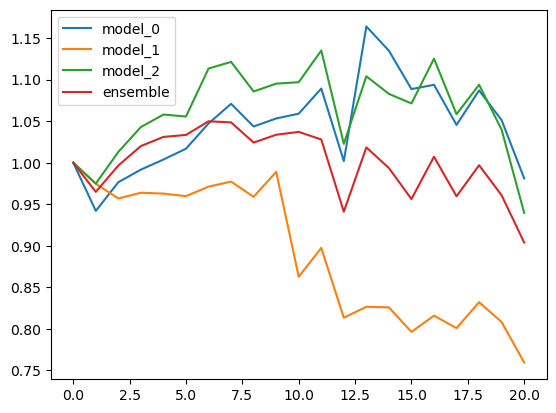

In [25]:
ftd = 0
ltd = 99
first_run = True
total_dict = {}
total_asset_dict = {}
position_dict_all = {}
for i in range(num_of_models + 1):
    total_dict[i] = 1
    total_asset_dict[i] = [1]
    position_dict_all[i] = {}

total_asset_dict, total_dict, position_dict_all = simulate(ftd, ltd, total_dict, first_run, total_asset_dict, position_dict_all)

# Retrain

Training data are from 2020-01-31 to 2020-06-23
Testing data are from 2020-05-28 to 2020-07-22
Training data have shape (197073, 20, 19), (197073,)
Testing data have shape (48660, 20, 19), (48660,)
Epoch 1/500
174/174 [==============================] - 28s 147ms/step - loss: 0.0603 - val_loss: 0.0541 - lr: 2.5000e-04
Epoch 2/500
174/174 [==============================] - 25s 144ms/step - loss: 0.0602 - val_loss: 0.0540 - lr: 2.5000e-04
Epoch 3/500
174/174 [==============================] - 25s 144ms/step - loss: 0.0601 - val_loss: 0.0542 - lr: 2.5000e-04
Epoch 4/500
174/174 [==============================] - 25s 144ms/step - loss: 0.0601 - val_loss: 0.0544 - lr: 2.5000e-04
Epoch 5/500
174/174 [==============================] - 25s 143ms/step - loss: 0.0600 - val_loss: 0.0543 - lr: 2.5000e-04
Epoch 6/500
174/174 [==============================] - 25s 144ms/step - loss: 0.0599 - val_loss: 0.0544 - lr: 2.5000e-04
Epoch 7/500
174/174 [==============================] - 25s 145ms/step - loss

174/174 [==============================] - 24s 139ms/step - loss: 0.0593 - val_loss: 0.0539 - lr: 1.2500e-04
Epoch 18/500
174/174 [==============================] - 24s 139ms/step - loss: 0.0593 - val_loss: 0.0542 - lr: 1.2500e-04
Epoch 19/500
174/174 [==============================] - 24s 139ms/step - loss: 0.0592 - val_loss: 0.0542 - lr: 1.2500e-04
Epoch 20/500
174/174 [==============================] - 24s 139ms/step - loss: 0.0592 - val_loss: 0.0542 - lr: 1.2500e-04
Epoch 21/500
174/174 [==============================] - 24s 139ms/step - loss: 0.0592 - val_loss: 0.0540 - lr: 1.2500e-04
Epoch 21: early stopping
49/49 [==============================] - 6s 120ms/step
Model 2 has training loss 0.05369074270129204
1521/1521 [==============================] - 12s 8ms/step
Model 2 has test loss 0.0322076641023159
Testing data from 2020-05-28 to 2020-06-24 have shape (2433, 20, 19), (2433,)
Simulating model 0
77/77 [==============================] - 1s 8ms/step
top_stocks by model_0 to buy

77/77 [==============================] - 1s 8ms/step
top_stocks by model_2 to buy on 2020-06-29 are ['DVY', 'EGLE', 'SPHD', 'SPYD', 'MDRX']
Sell CEIX on 2020-06-29 of market open
Sell TDW on 2020-06-29 of market open
Sell NOG on 2020-06-29 of market open
Sell UAL on 2020-06-29 of market open
Sell CIG on 2020-06-29 of market open
Hold [] on 2020-06-29 market open
Buy DVY on 2020-06-29 market open
Buy SPHD on 2020-06-29 market open
Buy SPYD on 2020-06-29 market open
Buy MDRX on 2020-06-29 market open
Buy EGLE on 2020-06-29 market open
position on 2020-06-30 market open will be {'DVY': 0.1893690229477793, 'SPHD': 0.19008580806073622, 'SPYD': 0.18952848895441807, 'MDRX': 0.19130773982097118, 'EGLE': 0.195057538001296}
Total asset on 2020-06-30 will be 0.9553485977852006
It should be the same as 0.9553485977852008
Simulating ensemble method
top_stocks by ensemble on 2020-06-29 are ['MNKD', 'MDRX', 'OVV', 'INSP', 'EGLE']
Sell CEIX on 2020-06-29 of market open
Sell NOG on 2020-06-29 of market

position on 2020-07-06 market open will be {'INO': 0.2043530478795704, 'RWR': 0.18763431628435157, 'OVV': 0.19868827003016298, 'MTDR': 0.18045925149409534, 'AYI': 0.18315781693964964}
Total asset on 2020-07-06 will be 0.9542927026278272
It should be the same as 0.95429270262783
Simulating model 1
77/77 [==============================] - 1s 8ms/step
top_stocks by model_1 to buy on 2020-07-02 are ['ERX', 'INO', 'WCC', 'SIG', 'NRGU']
Sell PDCO on 2020-07-02 of market open
Sell RWR on 2020-07-02 of market open
Sell HWM on 2020-07-02 of market open
Sell ACM on 2020-07-02 of market open
Sell CSTM on 2020-07-02 of market open
Hold [] on 2020-07-02 market open
Buy NRGU on 2020-07-02 market open
Buy SIG on 2020-07-02 market open
Buy INO on 2020-07-02 market open
Buy WCC on 2020-07-02 market open
Buy ERX on 2020-07-02 market open
position on 2020-07-06 market open will be {'NRGU': 0.16084539504192844, 'SIG': 0.15079255785180792, 'INO': 0.1702933452931357, 'WCC': 0.1546766221880206, 'ERX': 0.1597

top_stocks by ensemble on 2020-07-07 are ['OVV', 'PTEN', 'FCG', 'XOP', 'TEX']
Sell ALTM on 2020-07-07 of market open
Sell GD on 2020-07-07 of market open
Sell SIG on 2020-07-07 of market open
Sell SBLK on 2020-07-07 of market open
Sell EGLE on 2020-07-07 of market open
Hold [] on 2020-07-07 market open
Buy PTEN on 2020-07-07 market open
Buy XOP on 2020-07-07 market open
Buy FCG on 2020-07-07 market open
Buy OVV on 2020-07-07 market open
Buy TEX on 2020-07-07 market open
position on 2020-07-08 market open will be {'PTEN': 0.17815192435287963, 'XOP': 0.18023929438972866, 'FCG': 0.18130851406179432, 'OVV': 0.17914922582782955, 'TEX': 0.17872131779252276}
Total asset on 2020-07-08 will be 0.8975702764247545
It should be the same as 0.897570276424755
Testing data from 2020-06-09 to 2020-07-07 have shape (2433, 20, 19), (2433,)
Simulating model 0
77/77 [==============================] - 1s 8ms/step
top_stocks by model_0 to buy on 2020-07-08 are ['ICVT', 'ABM', 'AVEM', 'MNKD', 'OVV']
Sell AIR

position on 2020-07-13 market open will be {'ABM': 0.14916172230559105, 'ITCI': 0.1526039703572679, 'CQQQ': 0.1466104713006973, 'AXS': 0.15246392917785348, 'BLDP': 0.14948642496861758}
Total asset on 2020-07-13 will be 0.7503265181100267
It should be the same as 0.7503265181100272
Simulating model 2
77/77 [==============================] - 1s 8ms/step
top_stocks by model_2 to buy on 2020-07-10 are ['EFA', 'EWI', 'EWP', 'EUFN', 'EWD']
Sell BNTX on 2020-07-10 of market open
Sell EIDO on 2020-07-10 of market open
Sell IDEX on 2020-07-10 of market open
Sell ABM on 2020-07-10 of market open
Sell MNKD on 2020-07-10 of market open
Hold [] on 2020-07-10 market open
Buy EWD on 2020-07-10 market open
Buy EWP on 2020-07-10 market open
Buy EFA on 2020-07-10 market open
Buy EUFN on 2020-07-10 market open
Buy EWI on 2020-07-10 market open
position on 2020-07-13 market open will be {'EWD': 0.18953400198831943, 'EWP': 0.19050778723963993, 'EFA': 0.18765677113310691, 'EUFN': 0.1905070603130082, 'EWI': 

77/77 [==============================] - 1s 8ms/step
top_stocks by model_1 to buy on 2020-07-15 are ['IONS', 'BLV', 'FIXD', 'FXI', 'GXC']
Sell HUYA on 2020-07-15 of market open
Sell CLX on 2020-07-15 of market open
Sell MCHI on 2020-07-15 of market open
Hold ['GXC', 'FIXD'] on 2020-07-15 market open
Buy BLV on 2020-07-15 market open
Buy IONS on 2020-07-15 market open
Buy FXI on 2020-07-15 market open
position on 2020-07-16 market open will be {'GXC': 0.14050470158877357, 'FIXD': 0.1577957901683171, 'BLV': 0.1617734312362122, 'IONS': 0.16105649945976014, 'FXI': 0.15551372336373467}
Total asset on 2020-07-16 will be 0.7766441458167972
It should be the same as 0.7766441458167976
Simulating model 2
77/77 [==============================] - 1s 8ms/step
top_stocks by model_2 to buy on 2020-07-15 are ['NTLA', 'TXG', 'GRBK', 'AXNX', 'VCYT']
Sell ASHR on 2020-07-15 of market open
Sell OI on 2020-07-15 of market open
Sell REMX on 2020-07-15 of market open
Sell FATE on 2020-07-15 of market open
Ho

77/77 [==============================] - 1s 8ms/step
top_stocks by model_0 to buy on 2020-07-20 are ['PTC', 'IWM', 'IGT', 'FNGU', 'WSC']
Sell LNG on 2020-07-20 of market open
Sell GXC on 2020-07-20 of market open
Sell BE on 2020-07-20 of market open
Sell ETHE on 2020-07-20 of market open
Hold ['FNGU'] on 2020-07-20 market open
Buy PTC on 2020-07-20 market open
Buy WSC on 2020-07-20 market open
Buy IGT on 2020-07-20 market open
Buy IWM on 2020-07-20 market open
position on 2020-07-21 market open will be {'FNGU': 0.2007237442367868, 'PTC': 0.18203805823352204, 'WSC': 0.17777475187837669, 'IGT': 0.17434428546368516, 'IWM': 0.175432927311944}
Total asset on 2020-07-21 will be 0.9103137671243116
It should be the same as 0.9103137671243147
Simulating model 1
77/77 [==============================] - 1s 8ms/step
top_stocks by model_1 to buy on 2020-07-20 are ['MAA', 'FNGU', 'QURE', 'WSC', 'FR']
Sell MCHI on 2020-07-20 of market open
Sell BOIL on 2020-07-20 of market open
Sell WKHS on 2020-07-2

top_stocks by ensemble on 2020-07-22 are ['VXRT', 'IGT', 'BLV', 'EQT', 'LNG']
Sell FNGU on 2020-07-22 of market open
Sell REMX on 2020-07-22 of market open
Sell LIT on 2020-07-22 of market open
Sell HIMX on 2020-07-22 of market open
Hold ['IGT'] on 2020-07-22 market open
Buy BLV on 2020-07-22 market open
Buy EQT on 2020-07-22 market open
Buy VXRT on 2020-07-22 market open
Buy LNG on 2020-07-22 market open
position on 2020-07-23 market open will be {'IGT': 0.17005801146013047, 'BLV': 0.17363174361664005, 'EQT': 0.17563767996359764, 'VXRT': 0.16614176858750287, 'LNG': 0.16942584573770725}
Total asset on 2020-07-23 will be 0.8548950493655773
It should be the same as 0.8548950493655783
Testing data from 2020-06-24 to 2020-07-22 have shape (2433, 20, 19), (2433,)
Simulating model 0
77/77 [==============================] - 1s 8ms/step
top_stocks by model_0 to buy on 2020-07-23 are ['HCAT', 'AMCR', 'NIU', 'ICVT', 'VOX']
Sell IWM on 2020-07-23 of market open
Sell IHI on 2020-07-23 of market op

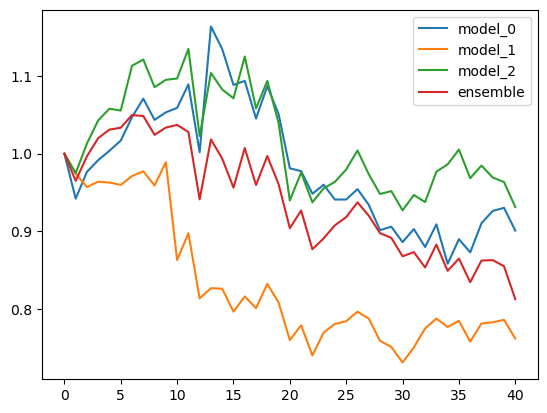

Training data are from 2020-03-02 to 2020-07-22
Testing data are from 2020-06-25 to 2020-08-19
Training data have shape (197073, 20, 19), (197073,)
Testing data have shape (48660, 20, 19), (48660,)
Epoch 1/500
174/174 [==============================] - 25s 140ms/step - loss: 0.0475 - val_loss: 0.0321 - lr: 1.0000e-04
Epoch 2/500
174/174 [==============================] - 24s 138ms/step - loss: 0.0474 - val_loss: 0.0321 - lr: 1.0000e-04
Epoch 3/500
174/174 [==============================] - 24s 138ms/step - loss: 0.0474 - val_loss: 0.0321 - lr: 1.0000e-04
Epoch 4/500
174/174 [==============================] - 24s 138ms/step - loss: 0.0473 - val_loss: 0.0321 - lr: 1.0000e-04
Epoch 5/500
174/174 [==============================] - 24s 138ms/step - loss: 0.0473 - val_loss: 0.0321 - lr: 1.0000e-04
Epoch 6/500
174/174 [==============================] - 24s 138ms/step - loss: 0.0472 - val_loss: 0.0321 - lr: 1.0000e-04
Epoch 7/500
174/174 [==============================] - 24s 139ms/step - loss

In [ ]:
num_of_days = len(all_days)

# Set the number of times to retrain
num_of_iter = 3
# Retrain all the rest (will take a very long time)
# num_of_iter = math.floor((num_of_days - 100) / 20) # 20 is the number of test days; 100 is the number of train days
first_run = False

for _ in range(1, num_of_iter):
    # Find train and test data
    ftd += 20
    ltd += 20 
    data_train, x_train, y_train, data_test, x_test, y_test, ret_d_train, ret_d_test, sic_train, sic_test = prep_train_test_data(data, seq_length, 
                                                                                                            ftd, ltd)
    # Retrain the model
    for i in range(num_of_models):
        
        history = model_dict[i].fit(
        x=[y_train, x_train, ret_d_train, sic_train],
        y=None,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks[i],
        validation_split=0.1,
        verbose=1,
        )

        # Find train and test loss
        y_pred = model_dict[i].predict([y_train, x_train, ret_d_train, sic_train], batch_size=4096)
        train_loss = custom_loss_np(y_train, y_pred, ret_d_train)
        print(f'Model {i} has training loss {train_loss}')
        y_pred = model_dict[i].predict([y_test, x_test, ret_d_test, sic_test])
        test_loss = custom_loss_np(y_test, y_pred, ret_d_test)
        print(f'Model {i} has test loss {test_loss}')

    # Simulate
    total_asset_dict, total_dict, position_dict_all = simulate(ftd, ltd, total_dict, first_run, total_asset_dict, 
                                                               position_dict_all)

# Remaining days (<20): still working on this

In [ ]:
num_of_days - ltd - 20 - 2
ftd = 180
ltd = 279

In [ ]:
print(ftd, ltd)

In [ ]:
remaining_days = num_of_days - ltd - 20 - 2 # remove the last day since there's no return
ftd += 20
ltd += 20
# def get_remaining_train_test_data(data, ftd, ltd):
first_train_day = all_days[ftd]
last_train_day = all_days[ltd]
first_test_day = all_days[ltd - seq_length + 2]
last_test_day = all_days[num_of_days - 2]
print(f'Training data are from {first_train_day} to {last_train_day}')
print(f'Testing data are from {first_test_day} to {last_test_day}')

data_train = data[(data['datadate'] >= first_train_day) & (data['datadate'] <= last_train_day)].reset_index(drop=True)
data_test = data[(data['datadate'] >= first_test_day) & (data['datadate'] <= last_test_day)].reset_index(drop=True)

# Compute how many training data we will have
all_train_days = list(data_train.datadate.unique())
all_test_days = list(data_test.datadate.unique())
num_train_days = len(all_train_days)
num_test_days = len(all_test_days)
num_train_data = (num_train_days - seq_length + 1) * nt
num_test_data = (num_test_days - seq_length + 1) * nt

# Create training data
x_train = np.zeros((num_train_data, len(factors), seq_length))
y_train = np.zeros((num_train_data, ))
ret_d_train = np.zeros((num_train_data, ))
for i in range(num_train_days - seq_length + 1):
    train_days = all_train_days[i : seq_length + i]
    data_temp = data_train[data_train['datadate'].isin(train_days)]
    # Convert dataframe data to three dimensional training data (ticker, factor, time-series data)
    # This is 'channels_first' type of data in training!; will change to channel last later!
    pivot_data = data_temp[factors+['datadate', 'tic']].pivot_table(index='tic', columns='datadate')
    x_train[i*nt:(i+1)*nt, :, :] = pivot_data.values.reshape(nt, len(factors), seq_length)
    y_train[i*nt:(i+1)*nt] = data_train[data_train['datadate'] == train_days[-1]]['rank'].values.reshape(nt, )
    ret_d_train[i*nt:(i+1)*nt] = data_train[data_train['datadate'] == train_days[-1]]['ret_d'].values.reshape(nt, )
    # probably wrong idea for increasing the dimension of y
    #y_train[i*nt:(i+1)*nt, 1] = data_train[data_train['datadate'] == train_days[-1]]['ret_d'].values.reshape(nt, )

# Create testing data
x_test = np.zeros((num_test_data, len(factors), seq_length))
y_test = np.zeros((num_test_data, ))
ret_d_test = np.zeros((num_test_data, ))
for i in range(num_test_days - seq_length + 1):
    test_days = all_test_days[i : seq_length + i]
    data_temp = data_test[data_test['datadate'].isin(test_days)]
    pivot_data = data_temp[factors+['datadate', 'tic']].pivot_table(index='tic', columns='datadate')
    x_test[i*nt:(i+1)*nt, :, :] = pivot_data.values.reshape(nt, len(factors), seq_length)
    y_test[i*nt:(i+1)*nt] = data_test[data_test['datadate'] == test_days[-1]]['rank'].values.reshape(nt, )
    ret_d_test[i*nt:(i+1)*nt] = data_test[data_test['datadate'] == test_days[-1]]['ret_d'].values.reshape(nt, )
    # probably wrong idea for increasing the dimension of y
    #y_test[i*nt:(i+1)*nt, 1] = data_test[data_test['datadate'] == test_days[-1]]['ret_d'].values.reshape(nt, )

# Reshape train/test data so that it is channels_last
x_train = np.transpose(x_train, (0, 2, 1))
x_test = np.transpose(x_test, (0, 2, 1))

# Let the label start with 0 to align with sparse cross-entropy
y_train[:] = y_train[:] + 2
y_test[:] = y_test[:] + 2

print(f'Training data have shape {x_train.shape}, {y_train.shape}')
print(f'Testing data have shape {x_test.shape}, {y_test.shape}')

In [ ]:
# Retrain the model
history = model.fit(
x=[y_train, x_train, ret_d_train],
y=None,
batch_size=batch_size,
epochs=epochs,
callbacks=callbacks,
validation_split=0.2,
verbose=1,
)

# Find test_loss
y_pred = model.predict([y_test, x_test, ret_d_test])
test_loss = custom_loss_np(y_test, y_pred, ret_d_test)
print(f'Test loss is {test_loss}')

# Simulate
total_asset, total, position_dict = simulate(ftd, ltd, total, False)

x_axis = [i for i in range(num_of_days-1)]
plt.plot(x_axis, total_asset)
plt.show()


In [ ]:
total_asset, total, position_dict = simulate(ftd, ltd, total, False)

x_axis = [i for i in range(len(total_asset))]
plt.plot(x_axis, total_asset)
plt.show()

In [ ]:
# Make Mar 11 prediction
data['datadate'] = pd.to_datetime(data['datadate'], format='%Y-%m-%d')
last_day_data = data[data['datadate'] >= pd.to_datetime('2024-2-9')]
pivot_data = last_day_data[factors+['datadate', 'tic']].pivot_table(index='tic', columns='datadate')
x_test = pivot_data.values.reshape(nt, len(factors), seq_length)
x_test = np.transpose(x_test, (0, 2, 1))

In [ ]:
y_test = np.zeros((nt, ))
ret_d_test = np.zeros((nt, ))
y_pred = model.predict([y_test, x_test, ret_d_test])

In [ ]:
y_pred

In [ ]:
sorted_indices = np.argsort(y_pred[:, -1])[::-1]
top_indices = list(sorted_indices[:10])
top_stocks = [num_to_tic_dict[num] for num in top_indices]
print(f'top_stocks on {all_days[-1]} are {top_stocks}')

In [ ]:
# This is from the previous (unrecoverable) model
# sorted_indices = np.argsort(y_pred[:, -1])[::-1]
# top_indices = list(sorted_indices[:10])
# top_stocks = [num_to_tic_dict[num] for num in top_indices]
# print(f'top_stocks on {all_days[-1]} are {top_stocks}')

# top_stocks on 2023-05-31 00:00:00 are ['SGML', 'MED', 'ASLE', 'BYND', 'AUPH', 'NOVA', 'IRBT', 'RIVN', 'HURC', 'CAR']